In [1]:
from kaggleImageFolder import KaggleImageFolder

In [2]:
root = 'data'
train_dir = root + '/train'
test_dir = root + '/test'
labels_file = 'labels.csv'
train_data = KaggleImageFolder(train_dir, labels_file, mode='train', split_p=0.2)


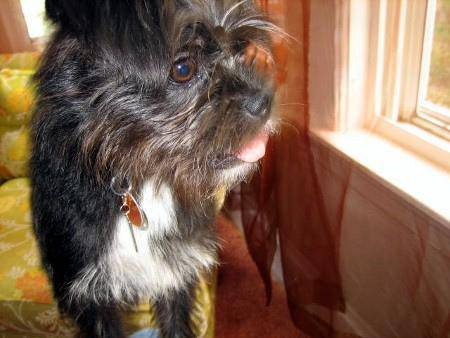

In [8]:
train_data[0][0]

In [9]:
print(len(train_data))
valid_data = KaggleImageFolder(train_dir, labels_file, mode='valid', split_p=0.2)
print(len(valid_data))
test_data = KaggleImageFolder(test_dir, mode='test')
print(len(test_data))

8177
2045
10357


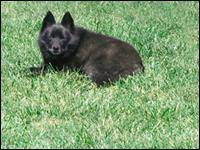

In [10]:
valid_data[0][0]

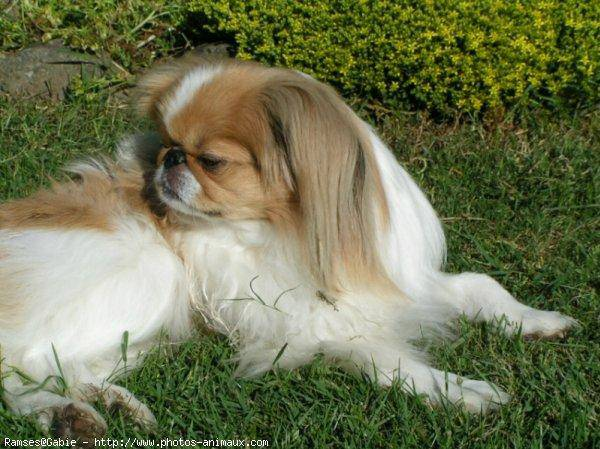

In [12]:
test_data[0]

In [8]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil 

%matplotlib inline

In [9]:
# 读取数据，处理label
data_labels = pd.read_csv('labels.csv')
# data_labels.set_index('id', inplace=True)
# data_labels.head()

In [10]:
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
breed_codes = data_labels['breed'].astype('category')
c = breed_codes.values

In [12]:
data_labels['label'] = c.codes
data_labels

,id,breed,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,10
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,10
7,002a283a315af96eaea0e28e7163b21b,borzoi,18
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,97


In [15]:
data_labels['label'].values

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [152]:
data_labels.groupby('breed').size().describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
dtype: float64

In [ ]:
pd.Series.name

In [35]:
data_labels.loc['000bec180eb18c7604dcecc8fe0dba07'].values[0]

'boston_bull'

In [45]:
g = os.walk(r"data/train")  

for i, (path,dir_list,file_list) in enumerate(g):  
    if i == 0:
        print(file_list)

#     for file_name in file_list:  
#         print(os.path.join(path, file_name) )

['000bec180eb18c7604dcecc8fe0dba07.jpg', '001513dfcb2ffafc82cccf4d8bbaba97.jpg', '001cdf01b096e06d78e9e5112d419397.jpg', '00214f311d5d2247d5dfe4fe24b2303d.jpg', '0021f9ceb3235effd7fcde7f7538ed62.jpg', '002211c81b498ef88e1b40b9abf84e1d.jpg', '00290d3e1fdd27226ba27a8ce248ce85.jpg', '002a283a315af96eaea0e28e7163b21b.jpg', '003df8b8a8b05244b1d920bb6cf451f9.jpg', '0042188c895a2f14ef64a918ed9c7b64.jpg', '004396df1acd0f1247b740ca2b14616e.jpg', '0067dc3eab0b3c3ef0439477624d85d6.jpg', '00693b8bc2470375cc744a6391d397ec.jpg', '006cc3ddb9dc1bd827479569fcdc52dc.jpg', '0075dc49dab4024d12fafe67074d8a81.jpg', '00792e341f3c6eb33663e415d0715370.jpg', '007b5a16db9d9ff9d7ad39982703e429.jpg', '007b8a07882822475a4ce6581e70b1f8.jpg', '007ff9a78eba2aebb558afea3a51c469.jpg', '008887054b18ba3c7601792b6a453cc3.jpg', '008b1271ed1addaccf93783b39deab45.jpg', '008ba178d6dfc1a583617470d19c1673.jpg', '009509be3ca7cce0ff9e37c8b09b1125.jpg', '0097c6242c6f3071762d9f85c3ef1b2f.jpg', '00a338a92e4e7bf543340dc849230e75.jpg',

In [46]:
root_dir = 'data'

def WinContig(root_dir, data_labels, data_for='train'):
    data_dir = os.path.join(root_dir, data_for)
   
    if os.path.exists(data_dir):
        # 遍历data_dir
        for path, _, file_list in os.walk(data_dir):
            for file_name in file_list:  
                img_path = os.path.join(path, file_name)
                img_label = data_labels.loc[file_name.split('.')[0]].values[0]
                class_path = os.path.join(path, img_label)
                if not os.path.exists(class_path):
                    os.mkdir(class_path)
                
                shutil.move(img_path, class_path)

In [47]:
# 整理图像文件结构为ImageFolder支持类型
WinContig(root_dir, data_labels)

In [48]:
# 读取数据
data_dir = 'data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [ ]:
train_data_transforms = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Ran
])